# World Data League 2023

## 🎯 Challenge
*Determining The Main Mobility Flows in the City 
of Lisbon Based on Mobile Device Data*


## Team: CEOS
## 👥 Authors
* Ana Maria Sousa
* Duarte Rodrigues
* Mariana Sousa
* Mariana Xavier
* Ricardo Brioso

## 💻 Development

In the last 40 years, 300,000 people have moved from the city of Lisbon to its outlying metropolitan area. Consequently, there is a need to improve the travel experience by public transport in order to decrease the number of people who use their cars for their commuting. Our goal is to understand the movement of people in the city and predict their behavior in the future, in order to  discover how different conditions affect the distribution of people.

We have five datasets: 

*   DISPOSITIVOS_MOVEIS_QUADRICULAS - Coordinates of the centroids of the 200x200 m squares, in the city of Lisbon
*   CONDICIONAMENTOS_TRANSITO - Registration of traffic conditioning/restrictions
*   DISPOSITIVOS_MOVEIS_GRELHA_E_EIXOS - information related to the active mobile phones per square of 200m/200m every 15 minutes , as well as, the ones entering and leaving the city.
*   Waze_QUEBRA_DE_SERIE - Registration of the traffic level and speed or dealy through the WAZE platform
*   (external dataset) LisboaAberta ["Monitorization of Environmental Parameters in the city of Lisbon"](https://dados.cm-lisboa.pt/dataset/monitorizacao-de-parametros-ambientais-da-cidade-de-lisboa) - Precipitation value in Lisbon registered in milimeters (mm)


All this information will be used to analyse, for every 15 minutes: 


*  how many people are located in each Lisbon zone (grid square);
*  if the city is in a rush hour;
*  if the overall city is congested;
*  if the overall city is slow delay;
*  how much is raining  on the entire city.










## Imports and requirements

In [2]:
# Requirements

!pip install basemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Imports

import os
import re
import ast
import json
import time
import warnings
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from datetime import datetime
from xgboost import XGBRegressor
from IPython.display import display
from mpl_toolkits.basemap import Basemap
from google.colab import drive, data_table
from matplotlib.colors import LinearSegmentedColormap
from sklearn import utils, preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [4]:
# Mount google drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Necessary functions

In [5]:
def inter_from_256(x):
  ''' Returns the result of interpolation from 256. '''

  return np.interp(x=x,xp=[0,255],fp=[0,1])


def build_custom_color_map():
  ''' Creates custom color map to be used for matplotlib plots. '''

  colors_dict = {
    'red':((0.0, inter_from_256(64), inter_from_256(64)),
           (1/5*1, inter_from_256(112), inter_from_256(112)),
           (1/5*2, inter_from_256(230), inter_from_256(230)),
           (1/5*3, inter_from_256(253), inter_from_256(253)),
           (1/5*4 ,inter_from_256(244), inter_from_256(244)),
           (1.0, inter_from_256(169), inter_from_256(169))),
    'green': ((0.0, inter_from_256(57), inter_from_256(57)),
            (1/5*1, inter_from_256(198), inter_from_256(198)),
            (1/5*2, inter_from_256(241), inter_from_256(241)),
            (1/5*3, inter_from_256(219), inter_from_256(219)),
            (1/5*4, inter_from_256(109), inter_from_256(109)),
            (1.0, inter_from_256(23), inter_from_256(23))),
    'blue': ((0.0, inter_from_256(144), inter_from_256(144)),
              (1/5*1, inter_from_256(162), inter_from_256(162)),
              (1/5*2, inter_from_256(246), inter_from_256(146)),
              (1/5*3, inter_from_256(127), inter_from_256(127)),
              (1/5*4, inter_from_256(69), inter_from_256(69)),
              (1.0, inter_from_256(69), inter_from_256(69))),
  }

  return LinearSegmentedColormap('custom_cmap', segmentdata=colors_dict)

## EDA - data quality and analysis

One of the first datasets to explore was the one which defines the grids that belong in the city of Lisbon to understand its potential.

Data fields: ['grelha_id' 'freguesia' 'latitude' 'longitude']
Number of records: 3743 

24 freguesias: ['Ajuda', 'Alcântara', 'Alvalade', 'Areeiro', 'Arroios', 'Avenidas Novas', 'Beato', 'Belém', 'Benfica', 'Campo de Ourique', 'Campolide', 'Carnide', 'Estrela', 'Lumiar', 'Marvila', 'Misericórdia', 'Olivais', 'Parque das Nações', 'Penha de França', 'Santa Clara', 'Santa Maria Maior', 'Santo António', 'São Domingos de Benfica', 'São Vicente'] 

Latitude [min, max]: [38.692094099, 38.7971892751] 

Longitude [min, max]: [-9.2304171489, -9.09027996458] 



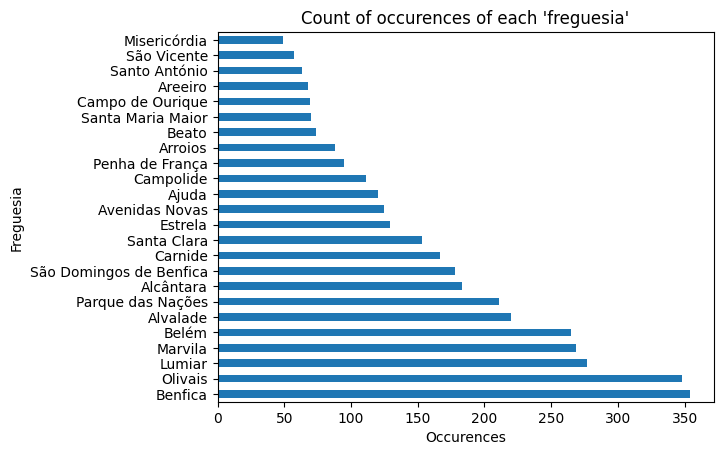

In [9]:
root_dir = '/content/drive/My Drive/DATA'
data_path = os.path.join(root_dir, 'DISPOSITIVOS_MOVEIS_QUADRICULAS',
                    'DISPOSITIVOS MOVEIS_QUADRICULAS.xlsx')

summarized_data = pd.read_excel(data_path, 'resumo')

print(f'Data fields: {summarized_data.columns.values}')
print(f'Number of records: {len(summarized_data.index)} \n')

freguesias_data = summarized_data.freguesia
unique_freguesias = freguesias_data.unique()
print(f'{len(unique_freguesias)} freguesias: {sorted(unique_freguesias)} \n')

latitude_data = summarized_data.latitude
min_max_latitude = [latitude_data.min(), latitude_data.max()]
print(f'Latitude [min, max]: {min_max_latitude} \n')

longitude_data = summarized_data.longitude
min_max_longitude = [longitude_data.min(), longitude_data.max()]
print(f'Longitude [min, max]: {min_max_longitude} \n')

summarized_data.freguesia.value_counts().plot(kind='barh',
                                              title = f'Count of occurences of each \'freguesia\'',
                                              xlabel='Occurences',
                                              ylabel='Freguesia');

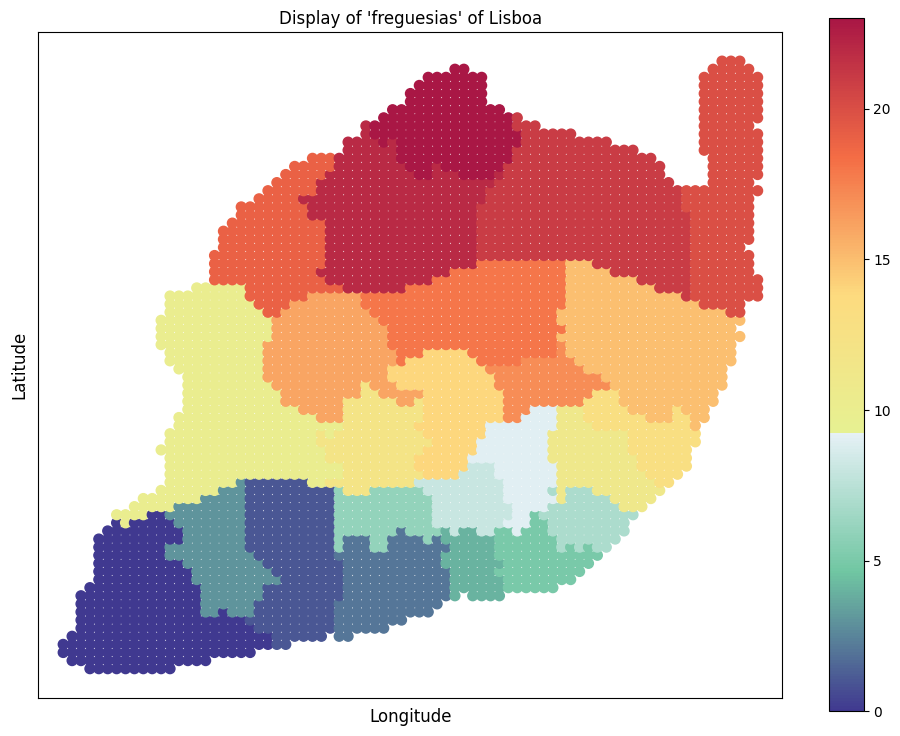

In [10]:
# Display of 'freguesias' of Lisboa using Basemap library

# Set the size of the map
fig = plt.figure(figsize=(12,9))

# Create the map
padding = 0.005
map = Basemap(projection='mill',
              llcrnrlat=min_max_latitude[0]-padding,
              urcrnrlat=min_max_latitude[1]+padding,
              llcrnrlon=min_max_longitude[0]-padding,
              urcrnrlon=min_max_longitude[1]+padding,
              resolution='c')

# Get additional variables needed for the display
encoded_labels = [np.where(np.array(list(dict.fromkeys(freguesias_data)))==e)[0][0] for e in freguesias_data]
color_map = build_custom_color_map()

# Plot the created map
map.scatter(longitude_data.tolist(), latitude_data.tolist(), latlon=True,
            s=50, c=encoded_labels, marker='o', alpha=1, cmap=color_map)
plt.title('Display of \'freguesias\' of Lisboa')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.colorbar()
plt.show()

## HOLD ON

In [11]:
root_dir = '/content/drive/My Drive/DATA'
data_path = os.path.join(root_dir, 'DISPOSITIVOS_MOVEIS_QUADRICULAS',
                    'DISPOSITIVOS MOVEIS_QUADRICULAS.xlsx')

In [12]:
root_dir = '/content/drive/My Drive/DATA/'
grid_path = os.path.join(root_dir,
                         'DISPOSITIVOS_MOVEIS_QUADRICULAS',
                         'DISPOSITIVOS MOVEIS_QUADRICULAS.xlsx')
transitConditioning_path = os.path.join(root_dir,
                                        'CONDICIONAMENTOS_TRANSITO',
                                        'CONDICIONAMENTOS TRANSITO_Set_Out_Nov2022.csv')
peopleSquares_path = os.path.join(root_dir,
                                  'DISPOSITIVOS_MOVEIS_GRELHA_E_EIXOS',
                                  'CML_DISPOSITIVOS MOVEIS_GRELHA_indCD15m_2022_09_0001_4000.csv')

# Waze Data for the month of September
path_waze1 = os.path.join(root_dir,"Waze_QUEBRA_DE_SERIE/Set2022/CML_waze_jams_092022_1.csv") 
path_waze2 = os.path.join(root_dir,"Waze_QUEBRA_DE_SERIE/Set2022/CML_waze_jams_092022_2.csv")
path_waze3 = os.path.join(root_dir,"Waze_QUEBRA_DE_SERIE/Set2022/CML_waze_jams_092022_3.csv")
path_waze4 = os.path.join(root_dir,"Waze_QUEBRA_DE_SERIE/Set2022/CML_waze_jams_092022_4.csv")

In [13]:
# meterological database to get the values of rain

# Online data scrapping to get the sensor locations from the available website
URL = 'http://opendata-cml.qart.pt/locations'
page = requests.get(URL)
sensor_loc_data = json.loads(page.text)

# for each rain sensor in Lisbon, it gets the correspondent geographic coordinates
rain_dict = {}
for locID in sensor_loc_data:
  for sensor in locID['sensors']:
    if 'ME00PP' in sensor['id']:
      rain_dict[sensor['id']] = [locID['coordinates']['lat'],locID['coordinates']['lng']]

#Online data scrapping process for the data of the specific sensors selected previously - rain
sensor_FullData_list = []
for sensor_name in rain_dict.keys():
  URL = 'http://opendata-cml.qart.pt/measurements/'+sensor_name+'?startDate=202209010000&endDate=202209302345' #september only
  page = requests.get(URL)
  sensor_data_list = json.loads(page.text)
  data_dict = {}
  for entry in sensor_data_list:
    data_dict[datetime.strptime(entry['date'], '%Y%m%d%H%M')] = entry["value"]
    
  sensor_FullData_list.append(data_dict)

# In this case there are 2 rain sensors - guarantee they have same number of entries - 1 entry per hour for all days
if len(sensor_FullData_list[0]) != len(sensor_FullData_list[1]):
    if len(sensor_FullData_list[0]) < len(sensor_FullData_list[1]):
        for key in sensor_FullData_list[1]:
            if key not in sensor_FullData_list[0]:
                sensor_FullData_list[0][key] = sensor_FullData_list[1][key]
    else:
        for key in sensor_FullData_list[0]:
            if key not in sensor_FullData_list[1]:
                sensor_FullData_list[1][key] = sensor_FullData_list[0][key]


# Extract keys
keys = sensor_FullData_list[0].keys()

# Initialize empty list to store values
values = [[] for _ in range(len(keys))]

# Loop through dictionaries and append values
for dict_ in sensor_FullData_list:
    for i, k in enumerate(keys):
        values[i].append(dict_[k])

# Create dataframe - at this step I realized Sensor1 had all values at 0 all the days! this was clearly wrong when compared to the other sensor, so I drop the column
rain_df = pd.DataFrame({k: v for k, v in zip(keys, values)}, index=['Sensor1','Sensor2']).T.drop(columns='Sensor1')

# To match the values of the WDL data, I need to resample the rain values to be the same within the hour, for the 4 intervals of 15 minutes
rain_df_15min = rain_df.resample('15T').ffill()
rain_df_15min.reset_index(inplace=True)
rain_df_15min.rename(columns={'index': 'Datetime', 'Sensor2':'SensorRain'}, inplace=True)
rain_df_15min.index = range(len(rain_df_15min ))

# To match the grid of the WDL, I need to assume the rain value is the same in all Lisbon, so all the grid has the same value, on the same 15min interval
rain_df_15min_grid = pd.DataFrame({'Datetime': rain_df_15min['Datetime'].repeat(3743), 'SensorRain': rain_df_15min['SensorRain'].repeat(3743)})
rain_df_15min_grid['Grid_ID'] = rain_df_15min_grid.groupby('Datetime').cumcount() + 1
rain_df_15min_grid['Datetime'] = pd.to_datetime(rain_df_15min_grid['Datetime'],utc=True)
rain_df_15min_grid.reset_index(inplace=True)

In [14]:
display(rain_df_15min_grid)

,index,Datetime,SensorRain,Grid_ID
0,0,2022-09-01 00:00:00+00:00,0.0,1
1,0,2022-09-01 00:00:00+00:00,0.0,2
2,0,2022-09-01 00:00:00+00:00,0.0,3
3,0,2022-09-01 00:00:00+00:00,0.0,4
4,0,2022-09-01 00:00:00+00:00,0.0,5
...,...,...,...,...
10768606,2876,2022-09-30 23:00:00+00:00,0.0,3739
10768607,2876,2022-09-30 23:00:00+00:00,0.0,3740
10768608,2876,2022-09-30 23:00:00+00:00,0.0,3741
10768609,2876,2022-09-30 23:00:00+00:00,0.0,3742


In order to be able to analyze the data it was necessary to perform the handling of the data from the different dataframes to enable their merging in a single dataframe table with the features of interest and their subsequent use in predictive models.

**Merge dataframes**

In this first analysis, we define as relevant features for the analysis of a predictive model: Grid id, Datetime and Number of people the grid registered for each datetime. And so these are the features contained in the dataframe that we will use as a starting point for the application of machine learning models. 

In [16]:
def get_grid_ids_by_freguesia(df_grid, freguesia):
    # Filter the dataframe by freguesia
    df_grid_filtered = df_grid[df_grid['freguesia'] == freguesia]
    
    # Get a list of the Grid_IDs in the filtered dataframe
    grid_ids = list(df_grid_filtered['Grid_ID'])
    
    return df_grid_filtered, grid_ids

In [19]:
# Read in data from Excel and CSV files

df_peopleSquares = pd.read_csv(peopleSquares_path, usecols=['Grid_ID', 'Datetime', 'C1'])
df_peopleSquares['Datetime'] = pd.to_datetime(df_peopleSquares['Datetime'],utc=True)
df_peopleSquares = df_peopleSquares.rename(columns={'C1': 'NumPeople'})

# Read in data from Excel and CSV files
df_grid = pd.read_excel(grid_path, sheet_name='resumo', usecols=['grelha_id', 'latitude', 'longitude', 'freguesia'])
df_grid.rename(columns={"grelha_id": "Grid_ID"}, inplace=True)
df_grid_filtered, grid_ids = get_grid_ids_by_freguesia(df_grid, 'Campolide')

# Creating the dataframe that for each grid square has all the 15 minute intervals between the dates below - (around 320.000 rows)
dt_range = pd.date_range(start='2022-09-01 00:00:00+00:00', end='2022-09-30 23:45:00+00:00', freq='15min')
df = pd.DataFrame({'Grid_ID': list(grid_ids)*len(dt_range), 'Datetime': list(dt_range)*len(grid_ids)})

# If any value is missing it appears as NaN
df = pd.merge(df, df_peopleSquares, on=['Grid_ID', 'Datetime'], how='left')

#Merge with the rain dataset
df = pd.merge(df, rain_df_15min_grid, on=['Grid_ID', 'Datetime'], how='left')
df['SensorRain'].fillna(0, inplace=True) # the last hour of the day was not resampled so it creates false NaN. This should have a value

def map_rain(val):
    if val > 0:
        return 1
    else:
        return 0

# Apply function to "SensorRain" column
df['SensorRain'] = df['SensorRain'].apply(map_rain)

df.drop(columns='index',inplace=True)

# Drop missing values (NaN) if exist 
df = df.dropna(subset=['NumPeople'])

#divide the datetime field in a three separated fields: 'hour' 'minute' and 'day_of_the_week'
df['hour'] = df['Datetime'].dt.hour
df['minute'] = df['Datetime'].dt.minute
df['day_of_the_week'] = df['Datetime'].dt.dayofweek

display(df)

,Grid_ID,Datetime,NumPeople,SensorRain,hour,minute,day_of_the_week
0,1011,2022-09-01 00:00:00+00:00,56.860001,0,0,0,3
1,1012,2022-09-01 00:15:00+00:00,110.230003,0,0,15,3
2,1013,2022-09-01 00:30:00+00:00,571.159973,0,0,30,3
3,1065,2022-09-01 00:45:00+00:00,44.860001,0,0,45,3
4,1066,2022-09-01 01:00:00+00:00,45.389999,0,1,0,3
...,...,...,...,...,...,...,...
319675,1661,2022-09-30 22:45:00+00:00,280.059998,0,22,45,4
319676,1664,2022-09-30 23:00:00+00:00,212.380005,0,23,0,4
319677,1718,2022-09-30 23:15:00+00:00,41.730000,0,23,15,4
319678,1719,2022-09-30 23:30:00+00:00,352.329987,0,23,30,4


**Machine learning models** 

We used 3 main models:

*   Random Forest Regression
*   Gradient Boosting Regression
*   XGB Regression

First of all we split the data into a training and testing sets.

Training set R^2 score: 0.8498833762782975
Test set R^2 score: 0.8155624606999679
Test set prediction R^2 score: 0.8155624606999679
Feature ranking:
1. feature 0 (0.696496)
2. feature 1 (0.191384)
3. feature 3 (0.096236)
4. feature 2 (0.013088)
5. feature 4 (0.002796)


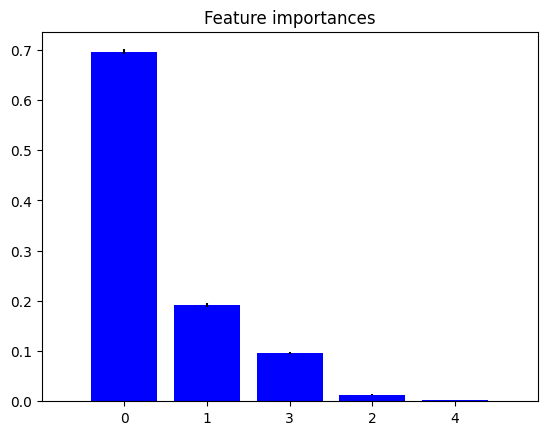

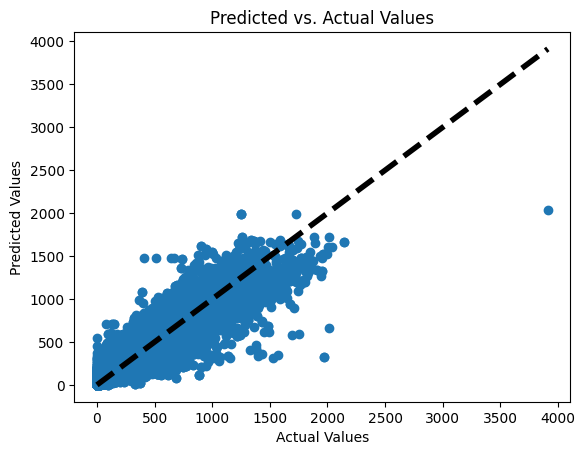

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Split data into training and testing sets
X = df[['Grid_ID', 'hour', 'minute', 'day_of_the_week','SensorRain']]
y = df['NumPeople']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the Random Forest model with best hyperparameters
rf_model = RandomForestRegressor(max_depth = None, min_samples_leaf = 2, min_samples_split = 5, n_estimators = 500)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

print("Training set R^2 score:", rf_model.score(X_train, y_train))
print("Test set R^2 score:", rf_model.score(X_test, y_test))

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Print the R^2 score on the predictions
print("Test set prediction R^2 score:", r2_score(y_test, y_pred))

# Save the model to a file
import joblib
joblib.dump(rf_model, 'rf_model.pkl')

# Generate feature importances plot
import matplotlib.pyplot as plt
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="b", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

# Plot predicted values against actual values for test set
plt.scatter(y_test, y_pred)
#plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.plot([0, 2500], [0, 2500], 'k--', lw=4)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values')
plt.show()

Test set prediction R^2 score: 0.8155624606999679
Feature ranking:
1. feature 0 (0.696496)
2. feature 1 (0.191384)
3. feature 3 (0.096236)
4. feature 2 (0.013088)
5. feature 4 (0.002796)


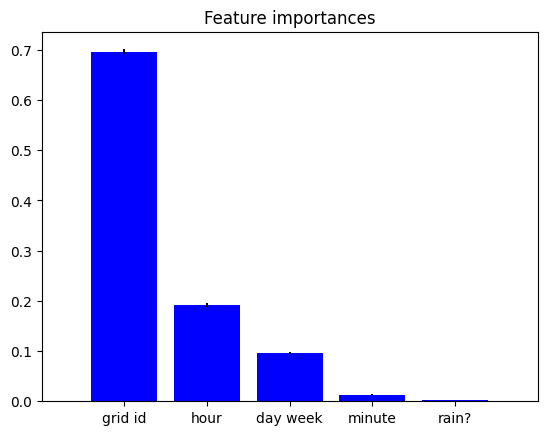

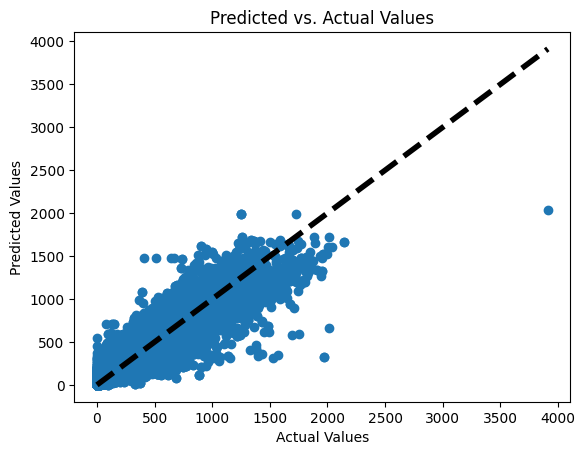

In [21]:
# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Print the R^2 score on the predictions
print("Test set prediction R^2 score:", r2_score(y_test, y_pred))

# Save the model to a file
import joblib
joblib.dump(rf_model, 'rf_model.pkl')

# Generate feature importances plot
import matplotlib.pyplot as plt
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="b", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), ['Grid_ID', 'Hour', 'Day week', 'Minute', 'Rain'])
plt.xlim([-1, X_train.shape[1]])
plt.show()

# Plot predicted values against actual values for test set
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values')
plt.show()

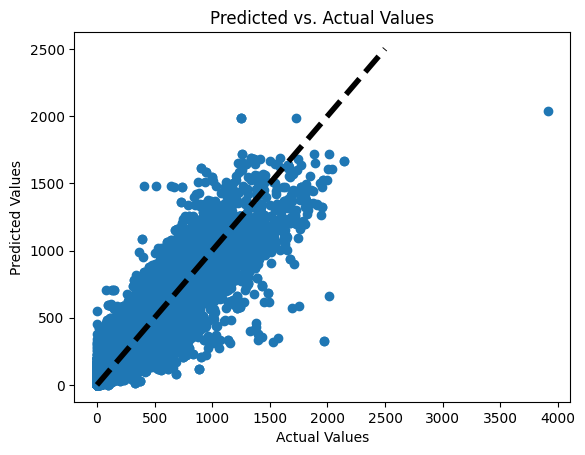

In [22]:
# Plot predicted values against actual values for test set
plt.scatter(y_test, y_pred)
#plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.plot([0, 2500], [0, 2500], 'k--', lw=4)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values')
plt.show()

In [ ]:
# Split data into training and testing sets
X = df[['Grid_ID', 'hour', 'minute', 'day_of_the_week','SensorRain']]
y = df['NumPeople']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Then we define the parameters grid from each model

In [ ]:
# Define the parameter grid for each model
param_grid_rf = {
    'n_estimators': [100, 500],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

param_grid_gb = {
    'n_estimators': [100, 500],
    'learning_rate': [0.01, 0.1],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

param_grid_xgb = {
    'n_estimators': [100, 500],
    'learning_rate': [0.01, 0.1],
    'max_depth': [None, 5, 10],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.8]
}

Finally we run the 3 models and compare them.

In [ ]:
# Create instances of each model
rf = RandomForestRegressor()
gb = GradientBoostingRegressor()
xgb = XGBRegressor()

# Create a list of tuples with the models and their corresponding parameter grids
models_params = [
    (rf, param_grid_rf),
    (gb, param_grid_gb),
    (xgb, param_grid_xgb)
]

# Loop through each model and its parameter grid, and perform a grid search
for model, param_grid in models_params:
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    print(f"Model: {type(model).__name__}")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Train MSE: {-grid_search.best_score_:.2f}")
    print(f"Test MSE: {-grid_search.score(X_test, y_test):.2f}")

## A acrescentar 

**MERGE - waze**

Read csv with the records of waze

In [ ]:
df_waze_N1 = pd.read_csv(path_waze1, sep=',',  usecols=[ 'entity_ts', 'level', 'length', 'delay','speed'])
df_waze_N2 = pd.read_csv(path_waze2, sep=',', usecols=[ 'entity_ts', 'level', 'length', 'delay','speed'])
df_waze_N3 = pd.read_csv(path_waze3, sep=',', usecols=[ 'entity_ts', 'level', 'length', 'delay','speed'])
df_waze_N4 = pd.read_csv(path_waze4, sep=',', usecols=[ 'entity_ts', 'level', 'length', 'delay','speed'])

frames = [df_waze_N1, df_waze_N2, df_waze_N3, df_waze_N4]
tb_waze_N = pd.concat(frames, ignore_index=True)

In [ ]:
def str_to_coord(string_list):
  coordlist=list()
  coord_list_string=list()
  for i in range(len(string_list)):
    string=string_list[i]
    
    if(isinstance(string, float)):
      c=((0, 0), (0,0))
      coordlist.append(c)
    else:
      # remove the curly braces from the string
      string = string.strip('{}')
  
      # split the string into key-value pairs
      pairs = string.split(',"')
      for pp in pairs:
        pp=re.findall("-?\d+\.\d+",pp)
        coord_list_string.append(np.reshape(pp, (int(len(pp)/2),2)))
        if(len(pp)>0):
            for p in range(len(pp)):
                pp[p]=float(pp[p])
            r=np.reshape(pp, (int(len(pp)/2),2))
            r=tuple(map(tuple, r.reshape((len(r), 2))))
            coordlist.append(r)
  
  return coordlist, coord_list_string  
  # test the function
postion, coord_list_string=str_to_coord(tb_waze_N['position'])
tb_waze_N['position']=postion

streets=(tb_waze_N['position'].drop_duplicates()).tolist()

In [ ]:
def distance(x, y):
    return np.sqrt((x - target_x) ** 2 + (y - target_y) ** 2)

street_list_grid=list()
coord_list=list()
for ii in range(len(streets)):
    path_wazegrid=list()
    path_waze=streets[ii]

    for coordenadas in range(len(path_waze)):
      target_x, target_y = path_waze[coordenadas][0], path_waze[coordenadas][1]
      closest_row = summarized_data.apply(lambda row: distance(row['longitude'], row['latitude']), axis=1).idxmin()

      if (closest_row in summarized_data_freg):
              path_wazegrid.append(closest_row)
              
    if(len(path_wazegrid)>0):    
        street_list_grid.append(list(set(path_wazegrid)))
        coord_list.append(streets[ii])

In [ ]:
decoding_grid=pd.DataFrame(list(zip(coord_list, street_list_grid)), columns=['position', 'Grid_position'])
tb_waze_N =pd.merge(tb_waze_N , decoding_grid, on=["position"])
tb_waze_N = tb_waze_N[tb_waze_N['position'].isin(coord_list)]
tb_waze_N=tb_waze_N.drop(columns=['position'])

In [ ]:
tb_waze_N=tb_waze_N.sort_values(by=['entity_ts'], ascending=True)

In [ ]:
#waze data
data = tb_waze_N['entity_ts']
tb_waze_N['datetime']=pd.to_datetime(tb_waze_N['entity_ts'])

#split day and time
data_list=list()
for ii in range(len(data.keys())):
  i=data.keys()[ii]
  data_list.append(data[i][:10])   #day list

tb_waze_N['day']=data_list  #create column day

data = pd.to_datetime(tb_waze_N['day']) # Convertendo a coluna de datas em um objeto DatetimeIndex
dia_da_semana = data.dt.weekday # Obtendo o dia da semana como uma série de números inteiros (segunda-feira = 0, domingo = 6)

dia_str = dia_da_semana #.apply(lambda x: ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado', 'Domingo'][x]) # Convertendo o dia da semana em uma série de strings
# Adicionando a nova coluna ao DataFrame
tb_waze_N['dia_da_semana'] = dia_str
tb_waze_N['delay/length']=tb_waze_N['delay']/tb_waze_N['length']
tb_waze_N=tb_waze_N.drop(columns=['delay', 'length','entity_ts', 'day']) #drop columns

In [ ]:
dt_range = pd.date_range(start='2022-10-01 00:00:00+00:00', end='2022-11-01 00:00:00+00:00', freq='15min')
count=0
posit=0
while count<len(tb_waze_N['datetime']):
  index=tb_waze_N['datetime'].keys()[count]
  actual_time=tb_waze_N['datetime'][index]
  for dt in range(posit, len(dt_range)-1):
    if (actual_time>=dt_range[dt] and actual_time<dt_range[dt+1]):

        tb_waze_N['datetime'][count]=dt_range[dt]
        posit=dt
        count=count+1
        break


In [ ]:
tb_waze_N=tb_waze_N.explode('Grid_position')
aggregation = {
   'dia_da_semana': 'first',
   'delay/length': ('max', lambda x: ((x > 0.9*x.max()) | (x < 0)).sum()),
   'level': (lambda x: sum(x > 4.5), 'count')
}

process_tbl=tb_waze_N.groupby(['datetime']).agg(aggregation) #grouping by 15min 

process_tbl['ratio_level (level>4,5)']=process_tbl['level']['<lambda_0>']/process_tbl['level']['count']  #ratio high level (>4.5) traffic by 15min
process_tbl['n_waze_search']=process_tbl['level']['count']  #number of waze users/seach
process_tbl['delay/length>0.9']=process_tbl['delay/length']['<lambda_0>'] 
process_tbl['day_of_week']=process_tbl['dia_da_semana']['first'] 
#dia_str = dia_da_semana.apply(lambda x: ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado', 'Domingo'][x]) # Convertendo o dia da semana em uma série de strings

process_tbl=process_tbl.drop(columns=['delay/length', 'level','dia_da_semana']) 

In [ ]:
from google.colab import data_table
data_table.DataTable(process_tbl, include_index=False, num_rows_per_page=10)

**Data handling- transit condicion** 

The function that was used for data handling was named "preprocess_transit_conditioning". This Function allows us to change the datetime format, get coordinates( maximum and minimum longitude and latitude ), identify the grid corresponding to the coordinates, and rename some columns of the dataframe.*Texto em itálico*

In [ ]:
def preprocess_transit_conditioning(df_transitConditioning, grid_ids, df_grid_filtered):

  df_transitConditioning['StartDatetime'] = np.zeros((len(df_transitConditioning)))
  df_transitConditioning['EndDatetime'] = np.zeros((len(df_transitConditioning)))

  for id in grid_ids:
    df_transitConditioning[str(id)] = np.zeros((len(df_transitConditioning)), dtype=int)

  for i, conditioning in df_transitConditioning.iterrows():

    conditioning_periods = conditioning['periodos_condicionamentos'][0]
    start_datetime = pd.to_datetime(conditioning_periods['date_min'] + ' ' + conditioning_periods['hour_max'] + '+00:00',
                                    format='%Y-%m-%d %H:%M:%S')
    df_transitConditioning['StartDatetime'][i] = start_datetime
    end_datetime = pd.to_datetime(conditioning_periods['date_max'] + ' ' + conditioning_periods['hour_min'] + '+00:00',
                                  format='%Y-%m-%d %H:%M:%S')
    df_transitConditioning['EndDatetime'][i] = end_datetime

    conditioning_coordinates = conditioning['position']['geometries'][0]['coordinates']
    min_longitude = conditioning_coordinates[0][0][0]
    max_longitude = conditioning_coordinates[0][1][0]
    min_latitude = conditioning_coordinates[0][0][1]
    max_latitude = conditioning_coordinates[0][1][1]

    for j, grid in df_grid_filtered.iterrows():

      longitude = grid['longitude']
      latitude = grid['latitude']

      if longitude >= min_longitude and longitude <= max_longitude and latitude >= min_latitude and latitude <= max_latitude:
        grid_id = str(int(grid['Grid_ID']))
        df_transitConditioning.at[i, grid_id] = 1

  df_transitConditioning = df_transitConditioning.drop(index = drop_rows)
  df_transitConditioning = df_transitConditioning.drop(columns=['position', 'periodos_condicionamentos'])
  df_transitConditioning = df_transitConditioning.rename(columns={"impacto": "Impact"})
  df_transitConditioning = df_transitConditioning.rename(columns={"restricao_circulacao": "RestrictionType"})

  return df_transitConditioning

## 🖼️ Visualisations
Copy here the most important visualizations (graphs, charts, maps, images, etc). You can refer to them in the Executive Summary.

Technical note: If not all the visualisations are visible, you can still include them as an image or link - in this case please upload them to your own repository.

## 👓 References

*   LisboaAberta ["Monitorization of Environmental Parameters in the city of Lisbon"](https://dados.cm-lisboa.pt/dataset/monitorizacao-de-parametros-ambientais-da-cidade-de-lisboa)



## ⏭️ Appendix
Add here any code, images or text that you still find relevant, but that was too long to include in the main report. This section is optional.
